<a href="https://colab.research.google.com/github/AndreaCamilloni/dd2412-deep-learning-advanced-fixmatch/blob/main/SimCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SimCLR

In this practial exercise, you are going to implement the famous SimCLR [1] algorithm for self-supervised learning. While not that old, it is often seen as the 'classic' approach to contrastive learning and it is still used as a baseline against which newer approaches are compared. Most of the more recent algorithms are just slight alterations of this approach, so knowing how it works will pay off in the future. Due to the growing amounts of data, self-supervised learning is likely to become more and more relevant in the future. 

Or as Yan LeCun and Ishan Misra put it: SSL may be helpful to unlock the [dark matter of intelligence](https://ai.facebook.com/blog/self-supervised-learning-the-dark-matter-of-intelligence/).

## Getting labels is expensive and can be ethically difficult

Regular supervised learning requires each data point to be labeled with ground truth information. Additionally, it requires large amounts of data. This unfortunately means that humans have to spend a lot of time hand-labeling data before we can train our networks. If determining the ground truth requires expert knowledge (e.g. diagnosing a disease based on a brain scan), getting large amounts of data is very expensive and time-consuming. In other cases, it can be very repetitive, mind-numbing work: "Click all images containing traffic lights." Since nobody wants to do this kind of work, it is often outsourced to crowd-workers who earn very little and have generally bad working conditions:
https://thegoodai.co/2021/02/03/who-is-labeling-your-data/

## SSL is a form of pretraining

Self-supervised learning now takes a bit of a different approach than supervised learning. It simply outsources the labeling to the computer! The computer *supervises itself*.

We first pretrain our model on a so-called *pretext task* using a large **unlabeled** dataset, then fine-tune it on a smaller, labeled dataset. The pretext tasks often consist of supervised learning, but use labels that the computer can automatically generate for any image. Afterwards, we finetune our model using regular supervised learning on a smaller dataset. 

One example for a pretext task would be to rotate the input image and let the network predict the degree of rotation. There's no need for human labeling, since the program has the information about how it rotated the image, so it can use that as a label right away. To solve the task, the network needs to learn e.g. that the sky is usually at the top of the image and that cars have their wheels on the bottom of the image. So it is forced to learn to recognise what the image contains, which is probably useful for the downstream task!

**Task** Come up with a simple pretext task yourself for any kind of dataset you like and describe it in a sentence or two. For example: "For pretraining a dataset of dog images, I would rotate the images and let the network predicted how the image was rotated." But don't simply use rotation, come up with something yourself!

Hint: Your program can change anything about the image and use information about that change to create a label. 

**Answer** 
Various Types of Transformations like mirroring, flipping, changing colors spaces etc

# Preparation

No need for you to implement the boring stuff. Just run the cells, we'll need it further down. 

In [1]:
%pip install jax-resnet optax umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 14.7 MB/s 
     |████████████████████████████████| 88 kB 9.0 MB/s 
     |████████████████████████████████| 185 kB 65.3 MB/s 
     |████████████████████████████████| 85 kB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 62.6 MB/s 
     |████████████████████████████████| 237 kB 67.5 MB/s 
     |████████████████████████████████| 51 kB 8.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=6d82cd7e0a7921d5b3ff9e2b6d874ede358d7135a835cd991b7f52ac1c02866c
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=9c523a68dd9352cdcfe2b5c1d5fb74e51f74b52418befc6e617c841b4b57b37c
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f

In [2]:
import torchvision
from jax import random
import numpy as np
from torch.utils import data
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
import jax
import optax
from flax.training import train_state
from typing import Any
import tqdm
import jax.numpy as jnp
import jax_resnet
from jax.config import config
import flax.linen as nn
from flax.core.frozen_dict import freeze, unfreeze
config.update("jax_debug_nans", True)

In [3]:
# Augmentation

# Slightly changed from source: 
# https://github.com/Spijkervet/SimCLR/blob/master/simclr/modules/transformations/simclr.py

class TransformsSimCLR:
    """
    A stochastic data augmentation module that transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x i and x j, which we consider as a positive pair.
    """

    def __init__(self, is_pretrain=True, is_val=False):
        self.is_pretrain=is_pretrain
        self.is_val=is_val
        s = 1
        color_jitter = torchvision.transforms.ColorJitter(
            0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s
        )
        self.train_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.RandomHorizontalFlip(),  # with 0.5 probability
                torchvision.transforms.RandomApply([color_jitter], p=0.8),
                torchvision.transforms.RandomGrayscale(p=0.2),
                torchvision.transforms.Lambda(np.array),
            ]
        )

        self.test_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Lambda(np.array),
            ]
        )

    def __call__(self, x):
        if self.is_pretrain:
          return self.train_transform(x), self.train_transform(x)
        else:
          if self.is_val:
            return self.test_transform(x)
          else:
            return self.train_transform(x)

In [4]:
def compute_validation_performance(state, val_data_loader):
  """
  Computes the given model's mean loss and accuracy on the validation set.
  """
  val_losses = []
  val_accs = []

  val_dl_tqdm = tqdm.tqdm(val_data_loader)

  for X, Y in val_dl_tqdm:
    
    loss, accuracy = eval_step(state, X, Y)
    val_losses.append(loss)
    val_accs.append(accuracy)

    val_dl_tqdm.set_postfix({'val_loss': loss.item(), 'val_acc': accuracy.item()})

  return jnp.array(val_losses).mean().item(), jnp.array(val_accs).mean().item()


@jax.jit
def eval_step(state, X, Y):

    logits = state.apply_fn({'params': state.params, 
                             'batch_stats': state.batch_stats}, X,
                              mutable=False)
    labels = jax.nn.one_hot(Y, num_classes=10)
    loss = optax.softmax_cross_entropy(logits, labels).mean()
    accuracy = jnp.mean(jnp.argmax(logits, -1) == Y)

    return loss, accuracy

In [5]:
# Data loader

# Source: https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html

def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

In [6]:
# Source: https://colab.research.google.com/drive/1Y2IiAG69nKQSoIKAOAWC8uypdP7TGFqF?usp=sharing#scrollTo=TqDvTL_tIQCH
def zero_grads():
    def init_fn(_): 
        return ()
    def update_fn(updates, state, params=None):
        return jax.tree_map(jnp.zeros_like, updates), ()
    return optax.GradientTransformation(init_fn, update_fn)

In [7]:
# Training functions

# Adapted from source: https://github.com/google/flax/blob/main/examples/mnist/train.py
# Parts that use batch norm adapted from https://github.com/google/flax/blob/main/examples/imagenet/train.py

@jax.jit
def apply_model(state, X1, X2):
  """Computes gradients, loss and accuracy for a single batch."""
  tau = 0.07
  def loss_fn(params):
    Z1, new_model_state = state.apply_fn({'params': params, 
                             'batch_stats': state.batch_stats}, X1,
                              mutable=['batch_stats'])
    Z2, new_model_state = state.apply_fn({'params': params, # We probably want to combine the two new model states, but how?
                             'batch_stats': state.batch_stats}, X2,
                              mutable=['batch_stats'])
    loss = NTXent(Z1, Z2, tau)
    return loss, (new_model_state, Z1, Z2)

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, (new_model_state, Z1, Z2)), grads = grad_fn(state.params)
  
  new_state = state.apply_gradients(
      grads=grads, batch_stats=new_model_state['batch_stats'])

  return (new_state, Z1, Z2), loss


@jax.jit
def apply_model_pos_only(state, X1, X2):
  """
  Computes gradients, loss and accuracy for a single batch,
  uing only positive pairs.
  """
  tau = 0.5
  def loss_fn(params):
    Z1, new_model_state = state.apply_fn({'params': params, 
                             'batch_stats': state.batch_stats}, X1,
                              mutable=['batch_stats'])
    Z2, new_model_state = state.apply_fn({'params': params, # TODO Amir: We probably want to combine the two new model states, but how?
                             'batch_stats': state.batch_stats}, X2,
                              mutable=['batch_stats'])
    loss = PositivesOnlyLoss(Z1, Z2)
    return loss, (new_model_state, Z1, Z2)

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, (new_model_state, Z1, Z2)), grads = grad_fn(state.params)
  
  new_state = state.apply_gradients(
      grads=grads, batch_stats=new_model_state['batch_stats'])

  return (new_state, Z1, Z2), loss

@jax.jit
def apply_model_supervised(state, X, Y):
  """
  Computes gradients, loss and accuracy for a single batch via supervised 
  training, not self-supervised training.
  """
    
  tau = 0.5
  def loss_fn(params):
    logits, new_model_state = state.apply_fn({'params': params, 
                             'batch_stats': state.batch_stats}, X,
                              mutable=['batch_stats'])
    labels = jax.nn.one_hot(Y, num_classes=10)
    loss = optax.softmax_cross_entropy(logits, labels).mean()
    accuracy = jnp.mean(jnp.argmax(logits, -1) == Y)
    return loss, (new_model_state, accuracy)

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, (new_model_state, accuracy)), grads = grad_fn(state.params)
  
  new_state = state.apply_gradients(
      grads=grads, batch_stats=new_model_state['batch_stats'])

  return (new_state, accuracy), loss


def pretrain_epoch(state, train_dl, positives_only=False):
  """
  Train for a single epoch.
  positives_only: Don't use negative pairs in contrastive training
  """

  epoch_loss = []
  epoch_accuracy = []

  train_dl_tqdm = tqdm.tqdm(train_dl)

  apply_fn = apply_model_pos_only if positives_only else apply_model

  for step, ((X1,X2), Y) in enumerate(train_dl_tqdm):

    (new_state, Z1, Z2), loss = apply_fn(state, X1, X2)
    state = new_state
    epoch_loss.append(loss)
    train_dl_tqdm.set_postfix({'train_loss': loss.item()})

  train_loss = np.mean(epoch_loss)
  return state, train_loss

def supervised_epoch(state, train_dl):
  """
  Train for a single epoch with supervised loss.
  """
  
  epoch_loss = []
  epoch_accuracy = []

  train_dl_tqdm = tqdm.tqdm(train_dl)

  for step, (X, Y) in enumerate(train_dl_tqdm):

    (new_state, accuracy), loss = apply_model_supervised(state, X, Y)
    state = new_state
    epoch_loss.append(loss)
    epoch_accuracy.append(accuracy)
    train_dl_tqdm.set_postfix({'train_loss': loss.item(), 'train_acc': accuracy})

  return state, jnp.array(epoch_loss).mean(), jnp.array(epoch_accuracy).mean()


class TrainState(train_state.TrainState):
  """
  Keeps track of the optimizer and updated parameters.
  """
  batch_stats: Any

def create_train_state(model, params, config, freeze_encoder=False):
  if freeze_encoder:
    tx = optax.multi_transform({'zero': zero_grads(), 
                                'sgd': optax.sgd(config["learning_rate"], 
                                                  config["momentum"])},
                                freeze({'backbone':'zero', 'head': 'sgd'}))
  else:
    tx = optax.sgd(config["learning_rate"], config["momentum"])
  return TrainState.create(
      apply_fn=model.apply, params=params["params"], tx=tx, 
      batch_stats=params["batch_stats"])
  

# Dataset

We are going to use the CIFAR10 dataset. It consists of 10 classes, each represented by 6000 RGB-images of size 32x32.

Have a look at a few images. 

In [8]:
full_pretrain_dataset = torchvision.datasets.CIFAR10(
        './cifar10',
        download=True,
        transform=TransformsSimCLR(is_pretrain=True, is_val=False),
        train=True
    )

full_supervised_dataset = torchvision.datasets.CIFAR10(
        './cifar10',
        download=True,
        transform=TransformsSimCLR(is_pretrain=False, is_val=False),
        train=True
    )

val_dataset = torchvision.datasets.CIFAR10(
        './cifar10',
        download=True,
        transform=TransformsSimCLR(is_pretrain=False, is_val=True),
        train=False
    )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Create a labeled dataset with only 1% of the labels
import torch
from sklearn.model_selection import StratifiedKFold

sk = StratifiedKFold(n_splits=100, shuffle=True, random_state=0)
splits = sk.split(np.zeros(len(full_supervised_dataset)), full_supervised_dataset.targets)
_, train_idc = list(splits)[0]

supervised_dataset_1p = torch.utils.data.Subset(full_supervised_dataset, train_idc)

pretrain_dataset = full_pretrain_dataset

Image x1 shape:  (32, 32, 3) 
Image x2 shape:  (32, 32, 3) 
class index y:  9 



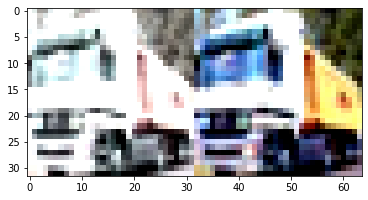

In [10]:
import matplotlib.pyplot as plt
import numpy as np

(x1,x2), y = pretrain_dataset[1]
print("Image x1 shape: ", x1.shape, 
      "\nImage x2 shape: ", x2.shape, 
      "\nclass index y: ", y, "\n")

merged_images = np.concatenate([x1,x2], axis=1)
plt.imshow(merged_images)

You maybe have noticed that the transformation module we use directly gives us two images instead of one. They are always two differently augmented versions of the same source image. This will be needed for SimCLR, which teaches the network to recognise that these two images show the same object, despite the differences introduced by the augmentations.

# Contrastive learning

The basic idea of contrastive learning is to learn by comparison. In the following image, the model is supposed to learn that the first two pictures show the same object, but the third one does not. Kind of like in the children's game Memory, where you try to find two matching tiles. Just... without the memory part. All the tiles are turned face up. 

Contrastive learning is a really stupid version of Memory.




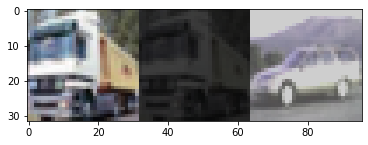

In [11]:
(x00,x01), y0 = pretrain_dataset[1]
(x10,x11), y1 = pretrain_dataset[4]
merged_images = np.concatenate([x00,x01,x10], axis=1)
plt.imshow(merged_images)

On a mathematical level, the model outputs a feature vector (an embedding) for each input image. The embeddings of similar images (like the two images on the left) are encouraged to move closer to each other, while embeddings of dissimilar images (middle and right image) should move away from each other.

This approach is fundamentally different from supervised learning. While supervised learning prescribes the exact output that the model is supposed to produce for a given input, contrastive learning only cares about the *relationship between different outputs*.

Image pairs that we, the user, define as similar are called **positive pairs**, all others are **negative pairs**.

## Similarity between images

We want to be able to measure how close or far the embeddings for different images are, to see if our model can tell positive and negative pairs apart. In SimCLR, this is done using the cosine similarity. For two d-dimensional embeddings $z_1$ and $z_2$, it provides a measure for how similar they are. 

$cos(z_1,z_2) = \frac{z_1}{|z_1|} \cdot \frac{z_2}{|z_2|}$

**Task** Implement the cosine similarity function below. It should also work if $Z_1$ and $Z_2$ are batches of shape [batch, features] and produce an output of shape [batch], containing the cosine similarities between the two feature vectors in the same row.

Hint: Using for-loops here works, but is really inefficient. The efficient implementation operates on matrices, not on individual elements. It mostly looks like the equation above. If you get a problem with broadcasting between different shapes when you try to normalize $Z_1$ and $Z_2$, the function jnp.expand_dims might be useful.

In [12]:
import jax.numpy as jnp

def cosine_similarity(Z1, Z2):
  """
  Z1, Z2: Batches of image embeddings of shape [Batch,EmbeddingDim]. Z1[i,:] and
          Z2[i,:] represent two differently augmented versions of the same image

  Returns: row-wise cosine similarity between row-vectors in Z1 and Z2, 
           shape [Batch]
  """

  Z1_norm = jnp.expand_dims(jnp.linalg.norm(Z1,axis=1),axis=1)
  Z1_normalised = Z1/Z1_norm

  Z2_norm = jnp.expand_dims(jnp.linalg.norm(Z2,axis=1),axis=1)
  Z2_normalised = Z2/Z2_norm

  cos_sims = jnp.diag(jnp.matmul(Z1_normalised,Z2_normalised.T))
  return cos_sims

  

Verify your implementation:

In [13]:
# Use these sample inputs to verify that your implementation is correct.
# You can interpret Z1 and Z2 as batches of image embeddings with eight features
# per image.

random_key_0, *subkeys = random.split(random.PRNGKey(0), 3)

#Batch size = 4
#Features = 8
Z1 = jnp.array(
    [[0.08780523,-1.4772962,0.23108286,0.3828757,0.42218092,-1.4358605,0.17658076,1.4141593],
    [-0.43024102,-0.2960915,0.64877045,1.0952688,0.10887499,2.5801923,-0.46863857,-0.07292866],
    [0.8462296,-0.9795519,-0.17020774,0.5177701,-1.2235159,0.56981355,1.1847981,-1.9526129],
    [-2.2450106,0.8794637,0.2156571,0.22987445,-0.8855504,0.180139,0.75102454,0.79618496]])

Z2 = jnp.array(
    [[0.78220856,-0.95930517,0.04278377,-0.14640434,-0.45225152,-0.164141,1.0146061,0.19397569],
    [-0.7706246,-0.35345954,-0.67818415,-1.1203834,-0.30522528,0.669694, 1.2020552,0.87423134],
    [0.43238065,-0.18009177,-0.13709433,-0.33463678,-1.1886245,-0.35386798,-1.0499382,0.10795221],
    [0.23042125,-1.5269405,0.771874,-0.1904757,-1.5630287,0.8980937,-1.9551364,-0.0497684]])
Z1.shape

(4, 8)

In [14]:
your_output = cosine_similarity(Z1, Z2)
desired_output = jnp.array([ 0.44447064, -0.02418898,  0.03658391, -0.19001874])

np.testing.assert_array_almost_equal(your_output, desired_output)

**Task** Wait a minute, why don't we just use the length of the difference vector $|z_1-z_2|$ instead of the cosine similarity? It's easier to compute, which could even speed up our training!

**Answer** 
|z1-z2| is not appropriate to compute the similarity. We want to give high similarity to vectors having similar directions. Cosine similarity allows us to have similar images in similar directions.

## Loss function

This is the point in the exercise where you need to think a bit. While the loss function is not very complex, you do need to figure out how you compute it for batched data. The paper only shows how to compute it for a single example. This is a problem that will often come up when implementing papers, so investing some time to work your brain will really pay off.

If you have tried for a bit and get stuck somewhere, feel free to use the hints below that are based on where the TA needed a bit longer for the implementation than he would have liked.

**Task** Implement the loss function (equation 1 in the paper) for a whole batch of image embeddings.

In [15]:
@jax.jit
def NTXent(Z1, Z2, tau):
  """
  Z1, Z2: Batches of image embeddings of shape [Batch,EmbeddingDim]. Z1[i,:] and
          Z2[i,:] represent two differently augmented versions of the same image
  tau   : Temperature parameter for softmax

  Returns: NTXent loss between Z1 and Z2, a single number
  """

  N = Z1.shape[0]
  Z1_Z2 = jnp.vstack([Z1,Z2])

  Z1_Z2_norm = jnp.expand_dims(jnp.linalg.norm(Z1_Z2,axis=1),axis=1)
  Z1Z2_normalised = Z1_Z2/Z1_Z2_norm


  cos_sims = jnp.matmul(Z1Z2_normalised,Z1Z2_normalised.T) #2N x 2N matrix

  exp_sims = jnp.exp(cos_sims/tau)

  eye_invert = (jnp.eye(2*N)==0).astype(int)

  denominator_sums = jnp.sum(exp_sims*eye_invert,axis=1)

  L = 0
  for i in range(N):
    l_ij = -jnp.log(exp_sims[i,N+i]/denominator_sums[i])
    l_ji = -jnp.log(exp_sims[N+i,i]/denominator_sums[i+N])
    l = l_ij+l_ji
    L += l

  L = L/(2*N)
  return L


Verify your implementation:

In [16]:
your_output = NTXent(Z1, Z2, 0.07)
desired_output = 6.792835

np.testing.assert_array_almost_equal(your_output, desired_output)

### Hint 1

Depending on how you programmed your cosine similarity, it may be more straight-forward to just recompute the similarities here instead of using your own function.

### Hint 2


The denominator contains all similarities between (i,k). Only the self-similarity (i,i) is left out. The similarity between (i,j) that's in the nominator is included in the denominator.

### Hint 3



You must compute the terms for both image pairs (i,j) _and_ (j,i). They will generally be different, even though on first glance they seem very similar.

### Hint 4

It's quite useful to have a matrix of all pairwise cosine similarities to compute everything you need. 

### Hint 5

Depending on how you implemented the cosine similarity, you might be able to compute the matrix of pairwise cosine similarities with the following line: 
`cosine_similarity(jnp.expand_dims(Zs, axis=1), jnp.expand_dims(Zs, axis=0))`

## Define the model

After coding the loss function, we now need a model that we can train with it!

We use a simple ResNet18 as our encoder model. It ends in a global average pooling, followed by a linear layer. We discard the linear layer and stick a projection head to the end of the model instead. 

You could also make use of that layer instead of removing it and then attaching a new linear layer as part of the projection head, but it's a bit cleaner this way.

In [17]:
# Load randomly initialized ResNet.

# n_classes doesn't matter, we remove the only layer impacted by it anyway.
# But we need to pass it to construct a ResNet. 
base_model = jax_resnet.ResNet18(n_classes=2) 

# Initialize the model's parameters. A dummy input is required to infer which 
# shape the parameters need to have
random_key_1, *subkeys = random.split(random_key_0, 3)
dummy_input = random.normal(subkeys[0],(8,32,32,3))
base_params = base_model.init(rngs=subkeys[1], x=dummy_input)

# Test whether everything works, 
# mutable=False ensures that batch_norm statistics aren't updated
output = base_model.apply(base_params, dummy_input, mutable=False)
output.shape, output.dtype

((8, 2), dtype('float32'))

In [18]:
# Source: https://www.kaggle.com/code/roguekk007/flax-model-surgery

class EncoderWithProjectionHead(nn.Module):
    encoder : nn.Sequential

    def setup(self):
        self.proj_head = nn.Sequential([
            nn.Dense(features=128), 
            nn.relu, 
            nn.Dense(features=128)
            ])

    def __call__(self, x):
        x = self.encoder(x)
        return self.proj_head(x)

# Use all of ResNet, except for the last layer
encoder = nn.Sequential(base_model.layers[:-1])
encoder_with_proj_head = EncoderWithProjectionHead(encoder=encoder)

random_key_2, subkey = jax.random.split(random_key_1)
pretrain_params = encoder_with_proj_head.init(subkey, dummy_input)

# Overwrite the randomly initialized parameters with the ones we got from pretraining
pretrain_params = unfreeze(pretrain_params)
pretrain_params['params']['backbone'] = base_params["params"] 
pretrain_params['batch_stats']['backbone'] = base_params["batch_stats"]
pretrain_params = freeze(pretrain_params)

# Test whether everything works
output = encoder_with_proj_head.apply(pretrain_params, dummy_input, mutable=False)
output.shape, output.dtype

((8, 128), dtype('float32'))

## Train the model using your loss function

Let's see what your loss function can do in practice! This should not take more than 2 minutes per epoch. If it does, make sure you are using a GPU environment.

In [19]:
config = {"learning_rate": 0.01, "momentum": 0.9}
pretrain_dataloader = NumpyLoader(pretrain_dataset, batch_size=128)

pretrain_state = create_train_state(encoder_with_proj_head, pretrain_params, config)

for epoch in range(5):

  pretrain_state, pretrain_loss = pretrain_epoch(pretrain_state, 
                                                 pretrain_dataloader)
  print(f"Epoch {epoch}: pretrain loss {pretrain_loss}")

100%|██████████| 391/391 [02:45<00:00,  2.36it/s, train_loss=0.331]


Epoch 0: pretrain loss 3.049849033355713


100%|██████████| 391/391 [01:54<00:00,  3.41it/s, train_loss=0.165]


Epoch 1: pretrain loss 0.3227316737174988


100%|██████████| 391/391 [01:55<00:00,  3.40it/s, train_loss=0.0827]


Epoch 2: pretrain loss 0.1672963947057724


100%|██████████| 391/391 [01:55<00:00,  3.38it/s, train_loss=0.0312]


Epoch 3: pretrain loss 0.11962350457906723


100%|██████████| 391/391 [01:55<00:00,  3.40it/s, train_loss=0.175]

Epoch 4: pretrain loss 0.09647758305072784


Hopefully you saw the loss going down! This is contrastive learning in practice. Simply by comparing positive and negative samples, the model gets trained. Of course, we still need to evaluate how useful the learned features are.

 But before that: Why do we even bother with negative pairs? 

## Intermezzo: Focusing on the positive


**Task** 
1. What would we need to change in our loss function to only use positive pairs? 
2. What do you think the effect would be on training?

Please answer this question before running the code below, which will give you the answer. You don't need to guess right, but you are expected to think about it and make an educated guess based on your understanding. 

**Answer**
* If we consider only positive pairs, we can simply use the cosine similarity and maximise it, in other words, the loss would be the negative of cosine similarities of positive pairs
* The model would end up giving similar embeddings to all inputs to maximise cosine similarity since there is no incentive to give different embeddings

**Task** Quickly write the loss function that only uses positive pairs, then run the code below to see whether your prediction was right.

In [20]:
@jax.jit
def PositivesOnlyLoss(Z1, Z2):
  L = -jnp.sum(cosine_similarity(Z1,Z2))/4
  return L

# Verify your solution
your_output = PositivesOnlyLoss(Z1, Z2)
desired_output = -0.06671171

np.testing.assert_array_almost_equal(your_output, desired_output)

In [21]:
# Train model using only positive pairs

# Note that we can use the same model and parameters as before, since these were
# not changed by the previous training. The updated parameters are stuck in 
# pretrain_state for now. This is part of the functional character of JAX.
positives_only_state = create_train_state(encoder_with_proj_head, 
                                          pretrain_params, config)

for epoch in range(1):

  positives_only_state, pretrain_loss = pretrain_epoch(positives_only_state, 
                                                       pretrain_dataloader, 
                                                       positives_only=True)
  print(f"Epoch {epoch}: {jnp.mean(pretrain_loss)}")


100%|██████████| 391/391 [02:24<00:00,  2.71it/s, train_loss=-20]

Epoch 0: -31.91294288635254


**Task** What did you observe? Why did this happen?

**Answer**
The Model has a low and a constant loss which does not reduce further. It might be giving the same embedding irrespective of the input to achieve this loss. Therefore, positiveonly loss as defined above would not be the best metric.

There are actually some more recent methods that *do* manage to use only positive pairs, without encoutering the problem you saw happen above. If you're interested how, look at one of these: [BYOL](http://arxiv.org/abs/2006.07733), [Barlow Twins](https://arxiv.org/abs/2103.03230), [SimSiam](https://arxiv.org/abs/2011.10566)

## Linear evaluation - How good are the features we learned?

To judge how good the features are that we learned, we want to test how useful they are for performing the task we actually care about. For this, we use the **linear evaluation** protocol. We take the trained model, discard the projection head and freeze all the model weights. We then add a single linear layer to perform our prediction task and evaluate its performance.

In JAX, freezing the weights is currently done by setting the gradients to zero. We have implemented that as part of create_train_state, so you will not see it in the code below.

In [22]:
# Source: https://www.kaggle.com/code/roguekk007/flax-model-surgery

class AddClassificationLayerToBackbone(nn.Module):
    backbone : nn.Sequential
    num_classes : int
        
    def setup(self):
        self.head = nn.Dense(self.num_classes)
    
    def __call__(self, x):
        x = self.backbone(x)
        return self.head(x)

backbone = encoder_with_proj_head.encoder
finetune_model = AddClassificationLayerToBackbone(backbone=backbone, 
                                                  num_classes=10)

random_key_3, subkey = jax.random.split(random_key_2)
finetune_params = finetune_model.init(subkey, dummy_input)

# Note: This unfreeze has nothing to do with the notion of freezing parameters.
# It only allows us to write into an otherwise write-protected FrozenDict.
finetune_params = unfreeze(finetune_params)

# Overwrite the randomly initialized parameters with the ones we got from pretraining
finetune_params['params']['backbone'] = pretrain_state.params["encoder"] 
finetune_params['batch_stats']['backbone'] = pretrain_state.batch_stats["encoder"]
finetune_params = freeze(finetune_params)

# Test whether everything works
output = finetune_model.apply(finetune_params, dummy_input, mutable=False)
output.shape, output.dtype

((8, 10), dtype('float32'))

### Finetune the model's last layer

In [23]:
supervised_train_dataloader = NumpyLoader(supervised_dataset_1p, batch_size=128)
val_dataloader = NumpyLoader(val_dataset, batch_size=128)

finetune_config = {"learning_rate": 0.01, "momentum": 0.9}
finetune_state = create_train_state(finetune_model, finetune_params, finetune_config, freeze_encoder=True)

for epoch in range(5):
  finetune_state, train_loss, train_acc = supervised_epoch(state=finetune_state, train_dl=supervised_train_dataloader)
  print(f"Epoch {epoch}: train loss {train_loss:.2f}, train accuracy {train_acc:.2f}")

  val_loss, val_acc = compute_validation_performance(finetune_state, val_dataloader)
  print(f"Epoch {epoch}: val loss: {val_loss:.2f}, val accuracy: {val_acc:.2f}\n")

100%|██████████| 4/4 [00:11<00:00,  2.90s/it, train_loss=2.39, train_acc=0.112068966]


Epoch 0: train loss 2.44, train accuracy 0.11


100%|██████████| 79/79 [00:04<00:00, 18.08it/s, val_loss=2.29, val_acc=0.0625]


Epoch 0: val loss: 2.33, val accuracy: 0.15



100%|██████████| 4/4 [00:00<00:00,  8.53it/s, train_loss=2.28, train_acc=0.1724138]


Epoch 1: train loss 2.29, train accuracy 0.18


100%|██████████| 79/79 [00:01<00:00, 55.06it/s, val_loss=2.3, val_acc=0.25]


Epoch 1: val loss: 2.23, val accuracy: 0.19



100%|██████████| 4/4 [00:00<00:00,  8.78it/s, train_loss=2.12, train_acc=0.2672414]


Epoch 2: train loss 2.14, train accuracy 0.26


100%|██████████| 79/79 [00:01<00:00, 53.27it/s, val_loss=2.3, val_acc=0.188]


Epoch 2: val loss: 2.16, val accuracy: 0.22



100%|██████████| 4/4 [00:00<00:00,  8.55it/s, train_loss=1.98, train_acc=0.3275862]


Epoch 3: train loss 2.02, train accuracy 0.29


100%|██████████| 79/79 [00:01<00:00, 52.99it/s, val_loss=2.31, val_acc=0.125]


Epoch 3: val loss: 2.12, val accuracy: 0.23



100%|██████████| 4/4 [00:00<00:00,  8.72it/s, train_loss=1.94, train_acc=0.3448276]


Epoch 4: train loss 1.95, train accuracy 0.31


100%|██████████| 79/79 [00:01<00:00, 53.39it/s, val_loss=2.34, val_acc=0.125]


Epoch 4: val loss: 2.12, val accuracy: 0.24



## Comparison to other methods

How well did our self-supervised training work? Below, you can see some values for comparison. All of them have only been run for a comparatively short time. The value in brackets indicates how many labeled images have been used in supervised training or supervised finetuning.
- Linear evaluation from random initialization and from an ImageNet-pretrained model only train the final linear layer of the network for 5 epochs.
- Fully supervised training starts from a randomly initialized network and trains the whole network for 5 epochs.
- SimCLR trains for 20 epochs on the full unlabeled training dataset. Then, the final linear layer is trained for 5 epochs.

| Method                                 	| Test set accuracy 	|
|----------------------------------------	|-------------------	|
| Linear evaluation from random initialization (100% labels)         	|     0.22              	|
| Linear evaluation from ImageNet pretraining (1% labels) |                    0.34                 	|
| Linear evaluation from ImageNet pretraining (100% labels) |                   0.41                 	|
| Full supervised training (1% labels)   	|   0.33                	|
| Full supervised training (100% labels) 	|   0.57                	|
| SimCLR training (1% labels)   	|    0.25               	|
| SimCLR training (100% labels)   	|  0.33                 	|

## Self-supervised learning: Great if you have few labels

Using self-supervision, we can make use of unlabeled data that would be useless to supervised approaches. This way, we can often achieve much better performance than pure supervised learning would achieve, especially if the labeled dataset is comparatively small. Depending on the setting, self-supervised approaches can even perform better than pure supervised approaches without using any additional unlabeled data.

**Task** In this exercise, the self-supervised model did not work as well as promised in the paper. Why is that? If you had access to any ressources you need, how would you change the setup to increase the performance and hopefully beat supervised training?

**Answer**
The model is trained only for 5 epochs. If we had access to more resources(i.e. GPU), introducing more epochs could hopefully increase the performance.

**Task** How long did it take you to complete this practical? This information is valuable to us to balance the difficulty of different practicals.

**Answer**
Around 5 hours

# References
[1] [Chen, Ting, et al. "A simple framework for contrastive learning of visual representations." International conference on machine learning. PMLR, 2020.](https://proceedings.mlr.press/v119/chen20j.html)